Although originally built for image processing with architecture similar to the visual cortex, CNNs have also been effectively used for text classification. In a basic CNN for image processing, an image tensor is convolved with a set of kernels of size d by d. These convolution layers are called feature maps and can be stacked to provide multiple filters on the input. To reduce the computational complexity, CNNs use pooling which reduces the size of the output from one layer to the next in the network. Different pooling techniques are used to reduce outputs while preserving important features.

The most common pooling method is max pooling where the maximum element is selected from the pooling window. In order to feed the pooled output from stacked featured maps to the next layer, the maps are flattened into one column. The final layers in a CNN are typically fully connected dense layers. In general, during the back-propagation step of a convolutional neural network not only the weights are adjusted but also the feature detector filters. A potential problem of CNN used for text is the number of 'channels', Sigma (size of the feature space). This might be very large (e.g. 50K), for text but for images this is less of a problem (e.g. only 3 channels of RGB). This means the dimensionality of the CNN for text is very high.

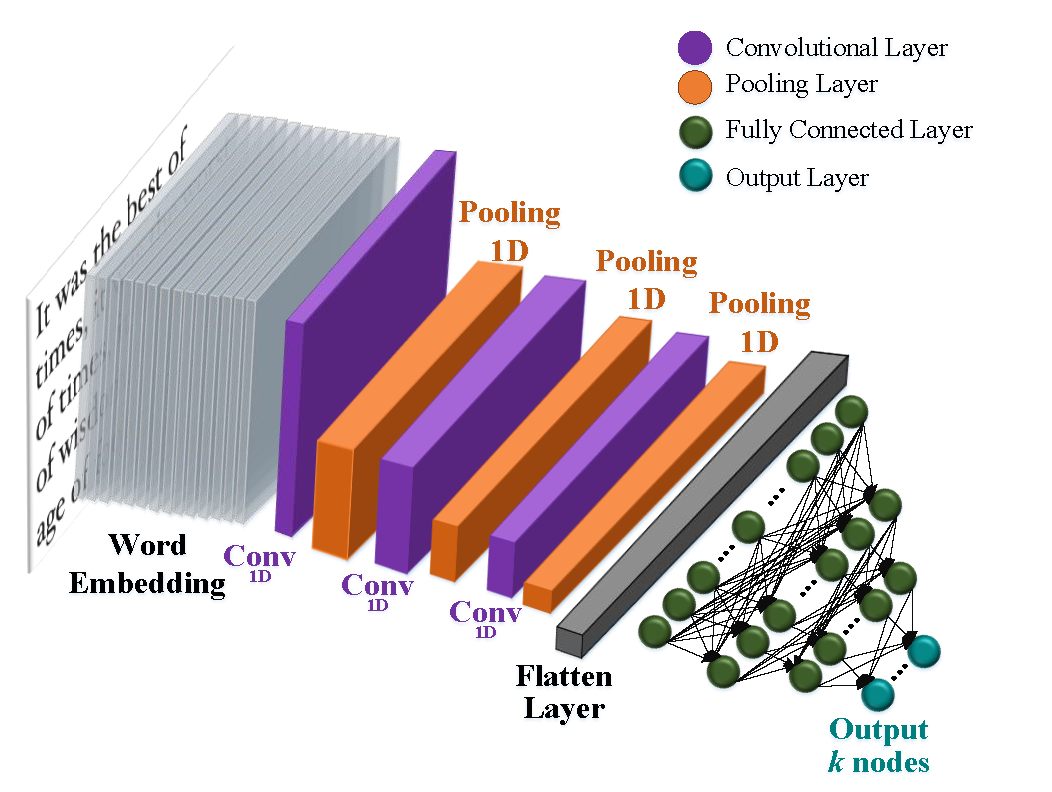

In [0]:
from keras.layers import Dropout, Dense,Input,Embedding,Flatten, MaxPooling1D, Conv1D
from keras.models import Sequential,Model
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.datasets import fetch_20newsgroups
from keras.layers.merge import Concatenate

In [0]:
#convert text to word embedding (Using GloVe):

def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open("C:\\Users\\kamran\\Documents\\GitHub\\RMDL\\Examples\\Glove\\glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

In [0]:
#Build a CNN Model for Text:

def Build_Model_CNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):

    """
        def buildModel_CNN(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
        word_index in word index ,
        embeddings_index is embeddings index, look at data_helper.py
        nClasses is number of classes,
        MAX_SEQUENCE_LENGTH is maximum lenght of text sequences,
        EMBEDDING_DIM is an int value for dimention of word embedding look at data_helper.py
    """

    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)

            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)

    # applying a more complex convolutional approach
    convs = []
    filter_sizes = []
    layer = 5
    print("Filter  ",layer)
    for fl in range(0,layer):
        filter_sizes.append((fl+2))

    node = 128
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(node, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        #l_pool = Dropout(0.25)(l_pool)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)
    l_cov1 = Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = Dropout(dropout)(l_cov1)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = Dropout(dropout)(l_cov2)
    l_pool2 = MaxPooling1D(30)(l_cov2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(1024, activation='relu')(l_flat)
    l_dense = Dropout(dropout)(l_dense)
    l_dense = Dense(512, activation='relu')(l_dense)
    l_dense = Dropout(dropout)(l_dense)
    preds = Dense(nclasses, activation='softmax')(l_dense)
    model = Model(sequence_input, preds)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])



    return model

In [0]:
#run CNN and see our result:

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
X_train = newsgroups_train.data
X_test = newsgroups_test.data
y_train = newsgroups_train.target
y_test = newsgroups_test.target

X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)


model_CNN = Build_Model_CNN_Text(word_index,embeddings_index, 20)


model_CNN.summary()

model_CNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=15,
                              batch_size=128,
                              verbose=2)

predicted = model_CNN.predict(X_test_Glove)

predicted = np.argmax(predicted, axis=1)


print(metrics.classification_report(y_test, predicted))